In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
hte = pd.read_pickle('../data/htev2.pkl')
import pdb

def get_energy_func(polymer, sm, solvent):
    criteria = (hte['SM']==sm)&(hte['polymer']==polymer)&(hte['solvent']==solvent)
    sys = hte[criteria]
    M = sys['dop'].to_list()[0]
    chi = sys.loc[:,['chi12', 'chi13', 'chi23']].values.squeeze().tolist()

    return M, chi

PARAMSET = 1
if PARAMSET==1:
    energy_func = lambda x : phase.polynomial_energy(x)
    use_polynomial = True
else:
    use_polynomial = False
    if PARAMSET==2:
        # toy params
        M = [5,5,1]
        chi = [1, 0.5, 0.5]
    elif PARAMSET==3:
        # dummy high dop
        M = [100,5,1]
        chi = [1, 0.5, 0.5]
    elif PARAMSET==4:
        # acetone
        M = [1626, 12.4, 1]
        chi = [0.44,1.48,1.9]
    elif PARAMSET==5:
        # Y6, P7B7-Th, Toluene
        M, chi = get_energy_func(sm = 'Y6', polymer = 'PTB7-Th', solvent = 'Toluene')
    elif PARAMSET==6:
        # IDTBR, P3HT, Chloroform
        M,chi = get_energy_func(sm = 'IDTBR', polymer = 'P3HT', solvent = 'Chloroform')
        
    configuration = {'M':M, 'chi':chi}
    energy_func = lambda x : phase.flory_huggins(x,configuration['M'],
                                                 configuration['chi'],beta=0.0)

    print(configuration)

In [16]:
engine = phase.PHASE(energy_func,100,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)

3-dimensional grid generated at 0.05s
Energy computed at 0.10s
Making energy manifold a paraboloid with 2x padding of 59.28 maximum energy
Energy is corrected at 0.26s
Convexhull is computed at 0.26s
Simplices are refined at 0.27s
Total of 325 simplices in the convex hull
Using 1.43E-01 as a threshold for Laplacian of a simplex
Simplices are labelled at 0.38s
Labels are lifted at 0.45s
Total 0/325 coplanar simplices
Computation took 0.45s


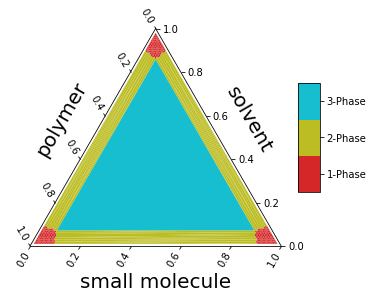

In [17]:
grid = engine.grid
num_comps = engine.num_comps
simplices = engine.simplices
energy = engine.energy
_energy = [energy_func(x) for x in engine.grid.T]

# phase.plot_lifted_label_ternary(out['output'])
phase.plot_mpltern(grid, simplices, num_comps)
plt.savefig('../figures/notebooks/toypd.png',bbox_inches='tight', dpi=500)
plt.show()

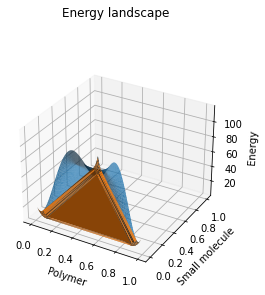

In [18]:
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})
phase.plot_energy_landscape(engine.as_dict(), mode='full', ax = ax)
phase.plot_energy_landscape(engine.as_dict(), mode='convex_hull', ax = ax)
plt.show()

In [19]:
CHI = phase._utri2mat(configuration['chi'],3)
def threecomp_gradphi_FH(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) -\
    CHI[0,2]*x[0] + (CHI[0,1] - CHI[1,2])*x[1] + CHI[0,2]*x[2]
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) +\
    (CHI[0,1] - CHI[0,2])*x[0] - CHI[1,2]*x[1] + CHI[1,2]*x[2]

    return [dEdx1, dEdx2]

def _grad_polynomial(x):
    
    grad = 2*(x-0.1)*(0.9-x)*(1-2*x)
    
    return grad*1e3

def polynomial_gradient(x,**kwargs):
    grad = []
    df_dx3 = 2*1e3*(0.9-x[0]-x[1])*(x[0]+x[1]-0.1)*(1-2*x[0]-2*x[1])
    for xi in x[:2]:
        df_dxi = _grad_polynomial(xi)
        grad.append(df_dxi + df_dx3)
        
    return grad

if use_polynomial:
    analytic_gradient = lambda phi : polynomial_gradient(phi)
else:
    analytic_gradient = lambda phi : threecomp_gradphi_FH(phi)

In [20]:
import matplotlib.tri as mtri

class CentralDifference:
    """Compute central difference gradinet of energy
    Works only for a 3-dimensional grid or a ternary system
    change the energy formulation
    """
    def __init__(self, grid, energy):
        if callable(energy):
            self.func = energy
        else:
            triang = mtri.Triangulation(grid[0,:], grid[1,:])
            self.interp_lin = mtri.LinearTriInterpolator(triang, energy)

    def __call__(self,phi, h = 1e-3):
        """
        x,y : coordinates (float)
        h   : gridspacing (float)

        """
        p1,p2,p3 = phi
        f_right = self.func([p1+h,p2,1-p1-h-p2])
        f_left = self.func([p1-h,p2,1-p1+h-p2])
        df_dx = (f_right - f_left)/(2*h)
        
        f_right = self.func([p1,p2+h,1-p1-h-p2])
        f_left = self.func([p1,p2-h,1-p1+h-p2])
        df_dy = (f_right - f_left)/(2*h)
        
        return [df_dx, df_dy]
    
    def plot_interpolated_energy(self):
        xi, yi = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
        z = self.func(xi, yi)
        fig, ax = plt.subplots()
        ax.contourf(xi, yi, z)
        plt.show()

centraldiff_gradient = CentralDifference(grid, energy_func)    
grad_cd = np.asarray([centraldiff_gradient(phi, h = 1e-6) for phi in grid.T])

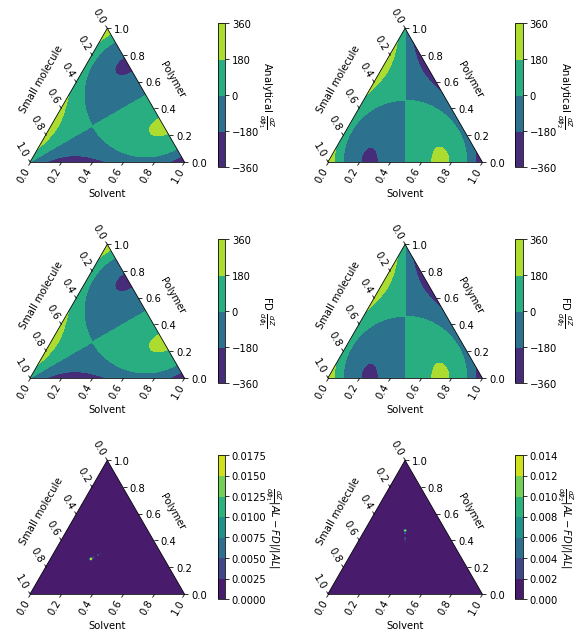

In [21]:
# Compare two gradient fields
import matplotlib.gridspec as gridspec

def plot_gradient_field(grid, gradient, ax,**kwargs):
    fig = plt.gcf()
    cs = ax.tricontourf(grid[0,:], grid[1,:], grid[2,:], gradient,**kwargs)
    cbar = fig.colorbar(cs, pad=0.15)    
    ax.set_tlabel('Polymer')
    ax.set_llabel('Small molecule')
    ax.set_rlabel('Solvent')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')
    ax.set_aspect('equal')
    return ax, cbar

fig = plt.figure(figsize=(3*5*1.6, 2*5))
gs = gridspec.GridSpec(nrows=3, ncols=2, wspace=0)
gs.update(wspace=0.35, hspace=0.5, left=0.1, right=0.4, bottom=0.1, top=0.9) 

grad = np.nan_to_num(np.asarray([analytic_gradient(x) for x in grid.T]))
grad_cd = np.nan_to_num(np.asarray([centraldiff_gradient(x, h = 1e-6) for x in grid.T]))

vmin=grad_cd.min()
vmax=grad_cd.max()
levels = np.linspace(vmin, vmax, num=5)

ax = fig.add_subplot(gs[0,0],projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,0], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(gs[0,1],projection='ternary')
ax,cbar = plot_gradient_field(grid, grad[:,1], ax, levels=levels)
cbar.set_label(r'Analytical (AL) $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')

ax = fig.add_subplot(gs[1,0],projection='ternary')
ax,cbar = plot_gradient_field(grid, grad_cd[:,0], ax, levels=levels)
cbar.set_label(r'Finite-difference (FD) $\frac{dZ}{d\phi_1}$', rotation=270, va='baseline')

ax = fig.add_subplot(gs[1,1],projection='ternary')
ax,cbar = plot_gradient_field(grid,grad_cd[:,1], ax, levels=levels )
cbar.set_label(r'Finite-difference (FD) $\frac{dZ}{d\phi_2}$', rotation=270, va='baseline')

ax = fig.add_subplot(gs[2,0],projection='ternary')
cvalue = np.abs(grad_cd[:,0]-grad[:,0])/np.abs(grad[:,0])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{dZ}{d\phi_1} |AL-FD|/|AL|$', rotation=270, va='baseline')

ax = fig.add_subplot(gs[2,1],projection='ternary')
cvalue = np.abs(grad_cd[:,1]-grad[:,1])/np.abs(grad[:,1])
ax,cbar = plot_gradient_field(grid, cvalue, ax)
cbar.set_label(r'$\frac{dZ}{d\phi_2} |AL-FD|/|AL|$', rotation=270, va='baseline')

plt.savefig('../figures/notebooks/trash.png', dpi=500)
plt.show()

In [22]:
test = phase.TestAngles(engine,phase=2)

Angle at vertex 0 is 179.25 degrees
Angle at vertex 1 is 172.76 degrees
Angle at vertex 2 is 179.24 degrees


/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/user/kiranvad/.venv/polyphase/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


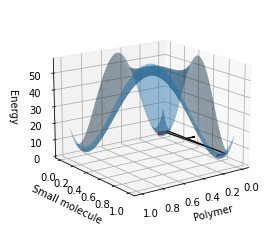

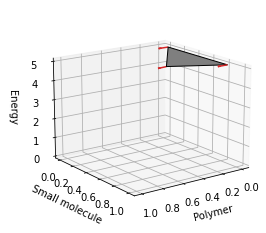

In [23]:
test_out = test.get_angles(centraldiff_gradient)
for key, value in test_out['thetas'].items():
    print('Angle at vertex {} is {:.2f} degrees'.format(key, value[2]))

fig,ax = test.visualize(required=[1,2])
plt.show()
fig,ax = test.visualize(required=[2])
plt.show()

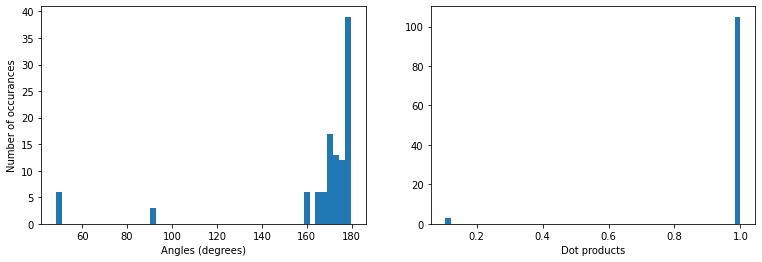

In [26]:
# get all angles of all 2-phase simplices
phase_simplices_ids = np.where(np.asarray(num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    test = phase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    test_out = test.get_angles(centraldiff_gradient)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)        
assert len(outlist)==len(phase_simplices_ids)*3    
fig, axs = plt.subplots(1,2,figsize=(2*4*1.6, 4))
axs[0].hist(outlist[:,0],bins=50, density=False)
axs[0].set_xlabel('Angles (degrees)')
axs[0].set_ylabel('Number of occurances')
axs[1].hist(outlist[:,1],bins=50, density=False)
axs[1].set_xlabel('Dot products')
plt.savefig('../figures/final/polynomial_angles_dotprods.png', dpi=400, bbox_inches='tight')

Vertex : [0.07070707999999999, 0.8585858599999999, 2.167218909270827]




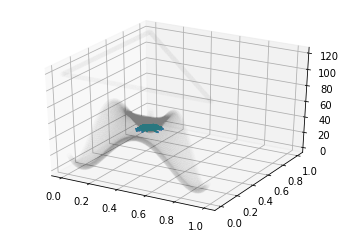

In [48]:
"""
Each vertex here is a parametric point with phi1, phi2, energy
For any vertex, the first neighbor is the point itself thus this would be angle reported in the figure above
"""
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import Isomap
scaler = MinMaxScaler()
samples = np.vstack((grid[:2,:],energy.reshape(1,-1))).T
isomap = Isomap(n_components=2, n_neighbors=16)
X = scaler.fit_transform(samples)
isomap.fit(X)
neigh = isomap.nbrs_
fig,ax = plt.subplots(subplot_kw={'projection':'3d'})

test = phase.TestAngles(engine,phase=3)
test.get_angles(centraldiff_gradient)

for tpp in test.parametric_points:
    print('Vertex : {}'.format(tpp))
    vertex = np.asarray(tpp)
    neigh_dist, neigh_ind = neigh.kneighbors(scaler.transform(vertex.reshape(1,-1)), n_neighbors=100)
    neighbors = samples[neigh_ind,:].squeeze()
    angles = []
    normals = []
    for i in neighbors:
        normal,_,_ = test._get_normal(i, centraldiff_gradient)
        angle = test._angle_between_vectors(test.facet_normal, normal)
        angles.append(angle)
        normals.append(normal)
    print('\n')
    angles = np.asarray(angles)
    normals = np.asarray(normals)
    unit_normals = normals/np.linalg.norm(normals, axis=1).reshape(-1,1)
    ax.scatter(samples[:,0], samples[:,1], samples[:,2], alpha=0.01, color='tab:gray')
    #ax.scatter(neighbors[:,0], neighbors[:,1],c=np.asarray(angles))
    ax.quiver(neighbors[:,0], neighbors[:,1], neighbors[:,2], 
              unit_normals[:,0], unit_normals[:,1], unit_normals[:,2],
              length=0.1, normalize=True)
    break
plt.show()

In [ ]:
import matplotlib.tri as tri

def get_griddata(x,y,z):
    xi = np.linspace(min(x), max(x), 20)
    yi = np.linspace(min(y), max(y), 20)
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    return xi, yi, zi
    
def plot_contour(x,y,z, ax):
    xi, yi, zi = get_griddata(x,y,z)
    CS = ax.contour(xi, yi, zi, linewidths=1.0, colors='k')
    ax.clabel(CS, inline=True, fontsize=10)
    cntr = ax.contourf(xi, yi, zi, cmap="RdBu_r")
    fig.colorbar(cntr, ax=ax)
    ax.plot(x, y, 'ko', ms=3)
    ax.plot(vertex[0], vertex[1],'*', color='magenta', ms=10)
    
    return

def show_zeorzero(x,y,z, ax):
    xi, yi, zi = get_griddata(x, y, z[:,0])
    ax.contour(xi, yi, zi, linewidths=1.0, colors='k', levels=[0])
    xi, yi, zi = get_griddata(x, y, z[:,1])
    ax.contour(xi, yi, zi, linewidths=1.0, colors='k', levels=[0])
    ax.plot(vertex[0], vertex[1],'*', color='magenta', ms=10)
    ax.set_xlim([0.06,0.08])
    ax.set_ylim([0.84,0.88])
    
fig = plt.figure(figsize=(3*4*1.6, 4))

ax = fig.add_subplot(131)
plot_contour(neighbors[:,0], neighbors[:,1], normals[:,0], ax)

ax = fig.add_subplot(132)
plot_contour(neighbors[:,0], neighbors[:,1], normals[:,1], ax)

ax = fig.add_subplot(133)
show_zeorzero(neighbors[:,0], neighbors[:,1], normals, ax)

plt.show()